# Project 2: Ames Housing Data and Kaggle Challenge

## Importing libaries

In [1]:
#Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

#To visualize the whole grid
pd.options.display.max_columns = 999

%matplotlib inline
plt.style.use('fivethirtyeight')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the data

In [2]:
#Importing datasets done in EDA & Cleaning
df = pd.read_csv('../datasets/df_combined_cleaned.csv')

## 4. Preprocessing

### 4.1 One-hot encode categorical variables
For categorical feature

In [3]:
# List out the columns with 'object' datatype
df.select_dtypes(include = [object]).columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation',
       'Bsmt Exposure', 'Heating', 'Central Air', 'Electrical', 'Garage Type',
       'Garage Finish', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'data_origin'],
      dtype='object')

In [4]:
#Instatiate 
le = LabelEncoder()

#New feature (categorical) for output
new_catfea = ['MS Zoning', 'Neighborhood', 'Sale Type']

for item in new_catfea:
    df[item] = le.fit_transform(df[item])     

In [5]:
#Get dummies:
df = pd.get_dummies(df, columns = new_catfea)

df.dtypes

Id              int64
PID             int64
MS SubClass     int64
Lot Area        int64
Street         object
                ...  
Sale Type_5     uint8
Sale Type_6     uint8
Sale Type_7     uint8
Sale Type_8     uint8
Sale Type_9     uint8
Length: 112, dtype: object

### 4.2 Export split cleand file

In [6]:
# Split the combined df into train & test again:
train = df.loc[df['data_origin'] == 'train']
test = df.loc[df['data_origin'] == 'test']

In [7]:
## Drop the 'data_origin' column plus addtional 'SalePrice' for test dataset
train.drop(['data_origin'], axis = 1, inplace = True)
test.drop(['data_origin', 'SalePrice'], axis = 1, inplace = True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [8]:
## Export cleaned split file
train.to_csv('../datasets/train_cleaned.csv', index = False)
test.to_csv('../datasets/test_cleaned.csv', index = False)  

### 4.3 Import splited file

In [9]:
df_train = pd.read_csv('../datasets/train_cleaned.csv')
df_test = pd.read_csv('../datasets/test_cleaned.csv')

### 4.2 Model Preparation
Create feature matrix (`X`) and target value (`y`)

Every **numerical** column (that is not the target) will be used as a feature.
The `SalePrice` column is the target


In [10]:
features = [col for col in df_train._get_numeric_data().columns if col != 'SalePrice']

X = df_train[features]
y = df_train['SalePrice']

create feature matrix for un-train data as matrix (`X_testuntrain`) from X_test dataset as well

In [11]:
X_testuntrain = df_test[features]

### 4.3 Train Test Split data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### 4.4 Model Scaling
Since will use `Lasso` and `Ridge` in modeling, will need to scale the features. 

In [13]:
ss = StandardScaler()
ss.fit(X_train)               #fit with X_train data, then use it to transform both X_train & X_test data

X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

X_testuntrain_sc = ss.transform(X_testuntrain)   # use the same fit with X_train data on the un-train dataset

## 5. Modeling

To evaluate `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [14]:
# Instantiate the 3 models:

lr = LinearRegression()

In [15]:
lasso = LassoCV(n_alphas = 500, verbose = 1)

In [16]:
ridge = RidgeCV(alphas = np.logspace(0, 5, 200))

### 5.1 Cross Validation
Use `cross_val_score` to evaluate all three models and select the one give the highest R2 score

#### 5.1.1 LinearRegression
- The mean R^2 is extremely negative. All the R^2 scores are negative in crossvalidation.
- It is probably dramatically overfitting and the redundant features are affecting the coefficients

In [17]:
lr_scores = cross_val_score(lr, X_train_sc, y_train, cv = 10)
print(f' The R2 score for LinearRegression is {round(lr_scores.mean(), 4)}')

 The R2 score for LinearRegression is -1.2040452372444574e+24


#### 5.1.2 Lasso 

- The R2 is much better than Linear Regression.
- This is expected as Lasso is able to help in feature selection, eliminating those in-significant feature (by zero-out the coefficient = 0). It is also able to manage multicollinearity


In [18]:
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv =10)
print(f' Lasso R2 score is {round( lasso_scores.mean() ,4)}')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

 Lasso R2 score is 0.8746


................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished


#### 5.1.3 Ridge

- The R2 is much better than Linear Regression.
- Again, it is likely there are too many features and it is able to manage the multicollinearity.
- Ridge and Lasso are getting fairly the same score, with Lasso (0.8917)is slightly higher than Ridge (0.8907).

In [19]:
ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv =10)
print(f' Ridge R2 score is {round( ridge_scores.mean() ,4)}')

 Ridge R2 score is 0.8764


### 5.2 Model Fitting and Evaluation

R2 for `LassoCV` (R2 : 0.8746) and `Ridge` (R2: 0.8764) are close to each other. Select Lasso to proceed for model fitting, as I would like to simplify the model, by zeroing out those very insignificant feature.

In [20]:
#Find an optimal value for Lasso regression alpha using LassoCV
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(X_train_sc, y_train)

print (f' Optimal lasso alpha : {optimal_lasso.alpha_}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

 Optimal lasso alpha : 0.002080494811445445


...........................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [21]:
## Cross validation the optimal lasso alpha with R2

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=10)

print (f' Lasso R2 score: {lasso_scores}')
print (f' Lasso R2 score (mean): {round(np.mean(lasso_scores), 4)}')

 Lasso R2 score: [0.91694197 0.92183619 0.8924947  0.93015963 0.84340017 0.93849508
 0.85433363 0.87165658 0.69667582 0.8829253 ]
 Lasso R2 score (mean): 0.8749


In [22]:
### Use the optimal alpha to fit into Lasso model
lasso.fit(X_train_sc, y_train)

Lasso(alpha=0.002080494811445445, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
print(f' Lasso R2 from trainning data: { round(lasso.score(X_train_sc, y_train), 4)}')

 Lasso R2 from trainning data: 0.9119


In [24]:
print(f' Lasso R2 from test data: { round(lasso.score(X_test_sc, y_test), 4)}')   

# the test data is from the train_test_split, not the test data provided from Kaggle

 Lasso R2 from test data: 0.8914


#### 5.2.1 Fitting the model
- R2 in cross validation on test data is not differ too much from the R2 in train data. Thus, the model is able to generalize well with future data.
- Use this model to get the predicted y (SalePrice)

In [25]:
# predict the target (y_predict), that is the SalePrice for un-train df_test dataset. 
y_pred = lasso.predict(X_testuntrain_sc)

#### 5.2.2 Export the Lasso model y-predict to csv

In [26]:
ID = df_test.Id  # this will be the 1st column data in output

# Convert the y-predict SalePrice to linear scale (from log scale)
y_pred_unlog = np.exp(y_pred)   # this will be the 2nd column data in output

header = ['Id', 'SalePrice']  # column header

data_tuples = list(zip(ID, y_pred_unlog))  # put the ID & corresponding y_pred as pairing

df_submission_lasso = pd.DataFrame(data_tuples, columns = header)

# Export to csv
df_submission_lasso.to_csv('../output/submission_lasso.csv', index = False)

#### 5.2.3 Getting coefficients

In [27]:
# create dataframe to store the lasso coefficient
lasso_coefs = pd.DataFrame({'features':X_train.columns,'lasso_coef':lasso.coef_})

lasso_coefs.sort_values('lasso_coef', inplace=True, ascending=False)
print(f'Percent features zeroed out: {round(np.sum((lasso.coef_ == 0))/float(X_train.shape[1])*100, 4)}%')

Percent features zeroed out: 26.1905%


In [28]:
print(f' number of feature retain by Lasso = {np.sum(lasso.coef_ != 0)}') 
print(f' feature zeroed out by Lasso = {np.sum(lasso.coef_ == 0)}')

 number of feature retain by Lasso = 62
 feature zeroed out by Lasso = 22


In [29]:
lasso_coefs

,features,lasso_coef
12,Gr Liv Area,0.129996
5,Overall Qual,0.074775
7,Year Built,0.063238
6,Overall Cond,0.040827
37,BasmtFinSF_type1,0.031334
...,...,...
40,MS Zoning_1,-0.017154
53,Neighborhood_7,-0.019000
26,Misc Val,-0.019398
2,MS SubClass,-0.024894


In [30]:
# Extract the top 15 positive and top 5 negative coefficient to plot out
imp_coef = pd.concat([lasso_coefs.head(15), lasso_coefs.tail(5) ])

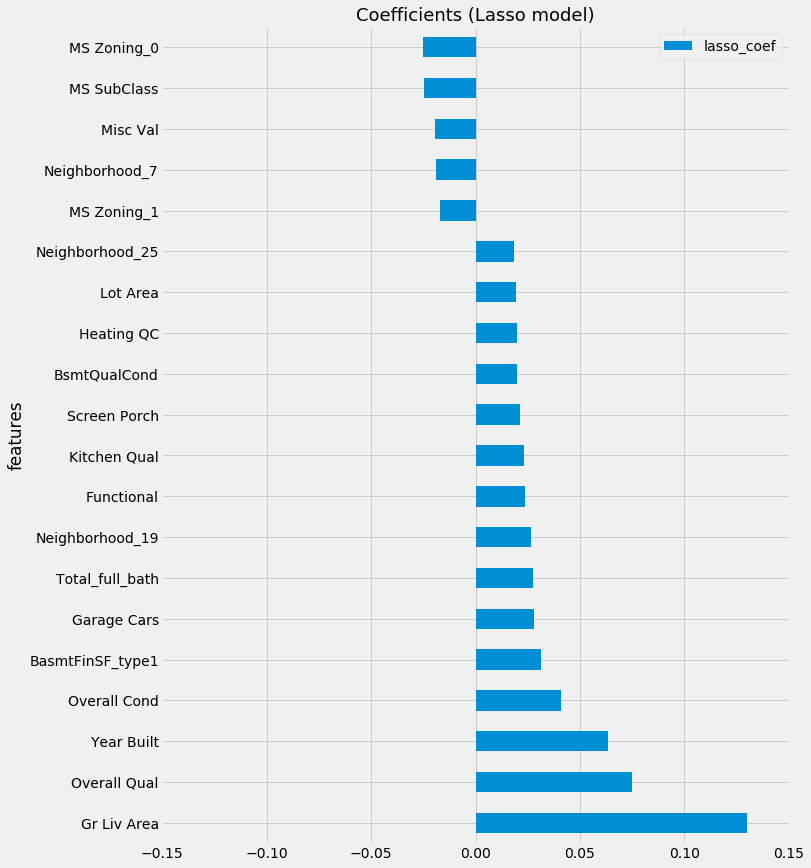

In [31]:
# Plot coefficients
plt.rcParams['figure.figsize'] = (10, 14)
imp_coef.plot(y = 'lasso_coef', x = 'features', kind = 'barh');
plt.title('Coefficients (Lasso model)', fontsize = 18);
plt.xlim(-0.15, 0.15);

The top 3 most significant positive features are Gr Liv Area, Overall Qual, Year built. These are actually the main driver to SalePrice. Asides, need to take note on the 2 most significant features that has negative impact on the SalePrice, which is the housing zone the the type of dweling.

#### Numeric features data dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**Gr Liv Area**|*int*|Continuous|Above grade (ground) living area square feet| 
|**Overall Qual**|*int*|Ordinal|Rates the overall material and finish of the house, where 1 to 10 = very poor to excelent| 
|**Year Built**|*int*|Discrete|Original construction date| 
|**Overall Cond**|*int*|Ordinal|Rates the overall condition of the house, where 1 to 10 = very poor to excelent| 
|**BsmtFinSF_type1**|*float*|Continuous|interaction feature between basement finished Type * its finishing area in square feet| 
|**Garage Cars**|*float*|Discrete|Size of garage in car capacity| 
|**Functional**|*obj*|Ordinal|Home functionality (Assume typical unless deductions are warranted), from typical to salvage only|
|**Kitchen Qual**|*obj*|Ordinal|Kitchen Quality| 
|**Screen Porch**|*float*|Continuous|Screen porch area in square feet|
|**BsmtQualCond**|*int*|Ordinal|interaction feature between basement, ie. the height of the basement * its general condition| 
|**Heating QC**|*float*|Ordinal|Heating quality and condition| 
|**Lot Area**|*float*|Continuous|Lot size in square feet| 
|**Neighborhood_25**|*obj*|Norminal|Stone Brook, Physical locations within Ames city limits| 
|**Neighborhood_19**|*obj*|Norminal|Northridge Heights, Physical locations within Ames city limits| 
|**Neighborhood_7**|*obj*|Norminal|Edwards, Physical locations within Ames city limits| 
|**MS Zoning_0**|*obj*|Norminal|Agriculture, Identifies the general zoning classification| 
|**MS Zoning_1**|*obj*|Norminal|Commercial, Identifies the general zoning classification| 
|**MS SubClass**|*obj*|Norminal|Identifies the type of dwelling involved in the sale| 
|**Misc Val**|*float*|Continuous|$Value of miscellaneous feature|

#### 5.2.3 Residuals

Text(0, 0.5, 'Residuals')

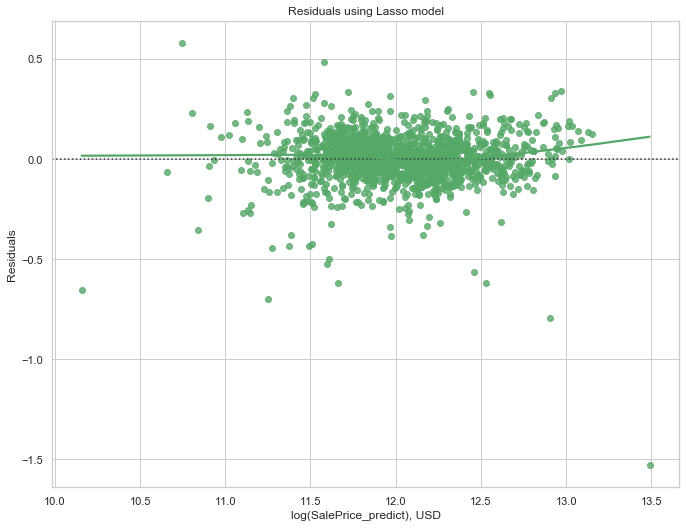

In [32]:
# Residuals plot (calculated based on fitting into Lasso model with X_train data)
sns.set(style="whitegrid")

pred_train = lasso.predict(X_train_sc)    # fit model with X_train data (after scalling)
residuals = y_train - pred_train          # calculate residuals

# Plot the residuals
plt.figure(figsize = (10,8));
sns.residplot(pred_train, y_train, lowess=True, color="g");
plt.title('Residuals using Lasso model')
plt.xlabel('log(SalePrice_predict), USD')
plt.ylabel('Residuals')

#### Residuals
The residuals of the Lasso model looks good as it randomly scatter around the zero horizontal line and the magnitude is relatively small as well.

## 6. Summary and Recommendation

### 6.1 Summary
#### Top 5 features with positive impact to housing SalePrice in Ames Iowa
Housing's size (living area in square feet) top the list as the most significant value added feature to housing price. 
Overall material and finish and overall condition of the house come in as second and fourth.
Timeline of the house is built is also value added to SalePrice with more recently built housing sold at higher price.
Basement finish (type 1) is also one of the key factor to add value to the SalePrice.
Other factor that has positive impact to SalePrice including the garage size, total number of full bathrooms, home functionality, kitchen and heating quality condition.

#### Features with negative impact to housing SalePrice
Location of the housing, in terms of the general zoning of the housing has negative impact. Agriculture and commercial and the top two features with negative impact on housing Price. The type of housing (MS SubClass) is also has some negative impact to SalePrice.

#### Neighborhoods with positive impact to housing SalePrice
Northridge Heights and Stone Brook, are the two neighborhoods that could be a good investment, as they has positive impact to housing SalePrice.

### 6.2 Recommendation
Size of housing is always the key to housing SalePrice, as normally buyer will evaluate the price per square feet of a house. Housing age is important factor as newer house (recently built house) has higher SalePrice. Based on the model, good maintenance of the housing can greatly improve its value as well. This means, the overall material and finish, the condition, functionality, kitchen & heating quality of the house contribute to positive impact to SalePrice. Another key factor that influence the SalePrice is the basement and garage. Better basement condition, bigger size basement, garage with large car capacity increase the housing value.
One factor that cannot be neglected is the general zoning of the housing has some impact on the SalePrice as well. Housing at Agriculture and Commercial estate tends to has lower value in their pricing.

### 6.3 
Though the model is able to predict well the sale price in Ames, Iowa, it cannot be generalized to other cities as there are quite a number of features that influencing factors are unique to Ames. For example, the housing age, the neighborhood. Asides, the baseline housing price per squre feet in other city maybe different from Ames,Iowa. Instead of revising model, new dataset on the other city is needed to do the modeling, but could consider using the similar approach learn here.
